<a href="https://colab.research.google.com/github/pscabral/Prezunic/blob/main/Vgg19_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/PhilJd/freiburg_groceries_dataset.git

In [ ]:
cd freiburg_groceries_dataset/src

In [ ]:
!python download_dataset.py

574710816/574710816 [==============================] - 17s 0us/step


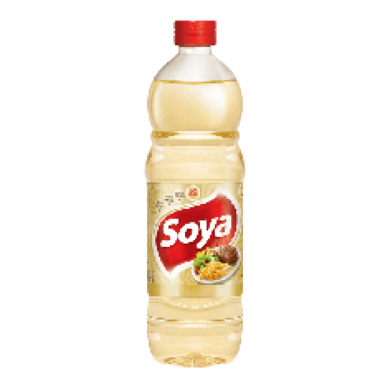

35363/35363 [==============================] - 0s 0us/step
water_bottle (29.42%)


In [4]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import decode_predictions
from keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt

# load the model
model = VGG19()

# load an image from file
image = load_img('/content/oleo.png', target_size=(224, 224))

# Display the image
plt.imshow(image)
plt.axis('off')  # Remove os eixos (bordas) da imagem
plt.show()

# convert the image pixels to a numpy array
image = img_to_array(image)

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# prepare the image for the VGG model
image = preprocess_input(image)

# predict the probability across all output classes
yhat = model.predict(image)

# convert the probabilities to class labels
label = decode_predictions(yhat)

# retrieve the most likely result, e.g. highest probability
label = label[0][0]

# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

In [ ]:
import os
import numpy as np
from PIL import Image
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Especificar o caminho para o diretório que contém as imagens
diretorio_imagens = '/content/freiburg_groceries_dataset/images/CHOCOLATE'

# Listar todos os arquivos no diretório de imagens
imagens = os.listdir(diretorio_imagens)

# Pré-processamento e carregamento das imagens
X = []
y = []

for imagem_nome in imagens:
    # Construir o caminho completo para a imagem
    caminho_imagem = os.path.join(diretorio_imagens, imagem_nome)

    img = Image.open(caminho_imagem)
    img = img.resize((224, 224))  # Redimensionar para o tamanho esperado pela VGG19
    img = np.array(img)
    img = preprocess_input(img)  # Pré-processamento específico da VGG19

    X.append(img)
    y.append(imagem_nome)  # Nome da imagem como rótulo

X = np.array(X)
y = np.array(y)

# Codificar os rótulos em números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Carregar o modelo VGG19 pré-treinado com pesos do ImageNet
base_model = VGG19(weights='imagenet', include_top=False)

# Adicionar camadas personalizadas para a tarefa de classificação
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar as camadas convolucionais para usar os pesos pré-treinados
for layer in base_model.layers:
    layer.trainable = False

# Compilar o modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Avaliar o modelo no conjunto de teste
accuracy = model.evaluate(X_test, y_test)[1]
print(f'Acurácia no conjunto de teste: {accuracy * 100:.2f}%')

In [ ]:
#!pip install gTTS
import cv2
import numpy as np
from keras.applications.vgg19 import preprocess_input
from google.colab.patches import cv2_imshow
from gtts import gTTS
import IPython.display as ipd

# Caminho para a imagem de teste
caminho_imagem_teste = '/content/TesteIMG/chocolate21.jpg'  # Substitua pelo caminho da sua imagem de teste

# Ler a imagem de teste
image = cv2.imread(caminho_imagem_teste)

# Redimensionar a imagem para o tamanho esperado pela VGG19
image_resized = cv2.resize(image, (224, 224))

# Adicionar a dimensão do lote (batch)
image_resized = np.expand_dims(image_resized, axis=0)

# Pré-processamento específico da VGG19
image_preprocessed = preprocess_input(image_resized)

# Fazer a previsão usando o modelo treinado
predicted_label = model.predict(image_preprocessed)

# Descodificar o rótulo previsto de volta para o nome da classe
predicted_class = label_encoder.inverse_transform([np.argmax(predicted_label)])[0]

# Exibir a imagem com a previsão
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(image, f'{predicted_class}', (10, 50), font, 1, (255, 0, 0), 2, cv2.LINE_AA)
cv2_imshow(image)

# Gerar o arquivo de áudio com o nome do produto previsto
tts = gTTS(text=f'O produto é {predicted_class}', lang='pt')
tts.save('/content/prevision.mp3')

# Reproduzir o arquivo de áudio
ipd.Audio('/content/prevision.mp3')

In [15]:
!apt-get install libzbar0
!pip install pyzbar

import cv2
from pyzbar.pyzbar import decode

def decode_qr_code(image_path):
    image = cv2.imread(image_path)
    decoded_objects = decode(image)
    return decoded_objects

def detect_and_display_barcodes(camera_id=0, window_name='OpenCV Barcode'):
    bd = cv2.barcode.BarcodeDetector()
    cap = cv2.VideoCapture(camera_id)

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        ret_bc, decoded_info, _, points = bd.detectAndDecode(frame)

        if ret_bc:
            frame = cv2.polylines(frame, points.astype(int), True, (0, 255, 0), 3)
            for s, p in zip(decoded_info, points):
                if s:
                    print(s)
                    frame = cv2.putText(frame, s, p[1].astype(int),
                                        cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.imshow(window_name, frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    image_path = "/content/CodigoBarrasIMG/01labeljoy-code-EAN13-1696292528360.png"
    decoded_objects = decode_qr_code(image_path)

    for obj in decoded_objects:
        print(f'Tipo: {obj.type}')
        print(f'Dado: {obj.data}')

    detect_and_display_barcodes()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common libdjvulibre-text libdjvulibre21 libfftw3-double3
  libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libjxr-tools libjxr0
  liblqr-1-0 libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra
  libmagickwand-6.q16-6 libv4l-0 libv4lconvert0 libwmflite-0.2-7 poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x libfftw3-bin libfftw3-dev inkscape poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common libdjvulibre-text libdjvulibre21 libfftw3-